In [4]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt
from pm4py.objects.log.importer.xes import factory as importer
from matplotlib import collections as mc
from matplotlib import cm
import pandas as pd
import numpy as np
import copy
%aimport BEP_PM

In [2]:
# log = importer.apply('C:/Users/20173939/Documents/Study/BEP/Road_Traffic_Fine_Management_Process.xes')
# rf = BEP_PM.EventLog('roadfines', 'concept:name', 'time:timestamp', log)
# rf.clean_timezone()
# rf.save()

In [185]:
# Reloading an already saved log named 'roadfines':
rf = BEP_PM.EventLog('roadfines', 'concept:name', 'time:timestamp', resource_id='org:resource')

In [186]:
rf.event_count

{('Create Fine', 'Send Fine'): 20755,
 ('Create Fine', 'Send for Credit Collection'): 58997,
 ('Create Fine', 'Payment'): 67201,
 ('Create Fine', 'Send Appeal to Prefecture'): 3144,
 ('Create Fine', 'Appeal to Judge'): 134,
 ('Create Fine', 'Notify Result Appeal to Offender'): 86,
 ('Create Fine', 'Receive Result Appeal from Prefecture'): 53}

In [187]:
# Manual reordering to match paper's segment order:
segments = rf.filter_segments()
segments[-1], segments[-2] = segments[-2], segments[-1] 
segments.insert(0, segments.pop(-1))
segments[-1], segments[-2] = segments[-2], segments[-1] 

In [188]:
height = 40
rf.performance_spectrum(segments, x_max=int(1500), segment_height=height)
rf.classify(rf.pf, metric=['start_time', 'end_time'], classifier=rf.batch_classifier, args=[10,0,1], inplace=True)

In [189]:
rf.pf['segment_index'] = (rf.pf['segment_index']) * 2

In [190]:
cols = list(rf.pf.columns)
cols.remove('segment_index')

In [206]:
# Using batch classifier to indicate if corrected trace was in a batch.
# This is because it is hard to see which traces where batched once the times have been adjusted.

# Sort per resource.
df = rf.pf.sort_values(['resource','start_time', 'end_time'])
current = None
last_end = None
prev = None
corrected = {}
causes = {}
busy = {}
for ind, row in df.iterrows():
    if row['resource'] != current: # Switching to new resource. 
        current = row['resource']
        last_end = None
    if last_end is not None and last_end['end_time'] > row['start_time']:
        # The worker was busy during the start of this event, correcting.
        if ind not in busy:
            busy[ind] = [ind]
        else:
            busy[ind].append(ind)
        corrected[prev] = row['start_time']
        if last_end['class'] == 1:
            causes[prev] = 1  # Batch is cause.
        else:
            causes[prev] = 0  # No batch, but still a cause. 
    last_end = row
    prev = ind
    
df['busy'] = df.index.map(busy)
df['waiting_time'] = df['end_time']- df.index.map(corrected)
df['end_time'] = df.index.map(corrected)
df['cause'] = df.index.map(causes)
df['batch'] = df['class']
df = df.sort_index()

In [193]:
for i in range(len(segments)):
    new_rows = df[df['segment_index'] == i*2][cols].copy()
    new_rows['segment_index'] = i*2+1
    rf.pf = rf.pf.append(new_rows, sort=True)

In [194]:
y_s = []
max_y = rf.pf['start_y'].max()
for segment in range(0, len(segments)*2):
    start =  (max_y*2) - (segment*height)
    end = (max_y*2) - (segment*height) - height
    rf.pf.loc[rf.pf['segment_index'] == segment, 'start_y'] = start
    rf.pf.loc[rf.pf['segment_index'] == segment, 'end_y'] = end
    y_s.append([start,end])
rf.y_s = y_s

In [195]:
new_segments = []
for segment in rf.segments:
    new_segments.append(segment)
    new_segments.append((segment[0], segment[1]+'1'))

In [196]:
rf.segments = new_segments

In [197]:
rf.pf

case_id  class  duration  end_time  end_y resource  segment_index  \
0         23766    0.0        10     500.0    440        9              0   
1         23767    2.0        90     238.0    360       27              2   
2         23767    1.0        19     257.0    280       27              4   
3         23767    1.0        60     317.0    200       27              6   
4         23767    2.0        23     340.0    120       27              8   
...         ...    ...       ...       ...    ...      ...            ...   
128762   150364    1.0       376    1094.0      0       25             11   
128766   150365    1.0       371    1100.0      0       25             11   
128771   150367    1.0       372    1098.0      0       25             11   
128775   150368    1.0       376    1096.0      0       25             11   
128779   150369    1.0       372    1099.0      0       25             11   

                                     segment_name  start_time  start_y  
0                          (Create Fine, Payment)         490      480  
1                        (Create Fine, Send Fine)         148      400  
2           (Send Fine, Insert Fine Notification)         238      320  
3         (Insert Fine Notification, Add penalty)         257      240  
4                          (Add penalty, Payment)         317      160  
...                                           ...         ...      ...  
128762  (Add penalty, Send for Credit Collection)        1094       40  
128766  (Add penalty, Send for Credit Collection)        1099       40  
128771  (Add penalty, Send for Credit Collection)        1098       40  
128775  (Add penalty, Send for Credit Collection)        1094       40  
128779  (Add penalty, Send for Credit Collection)        1098       40  

[257560 rows x 10 columns]

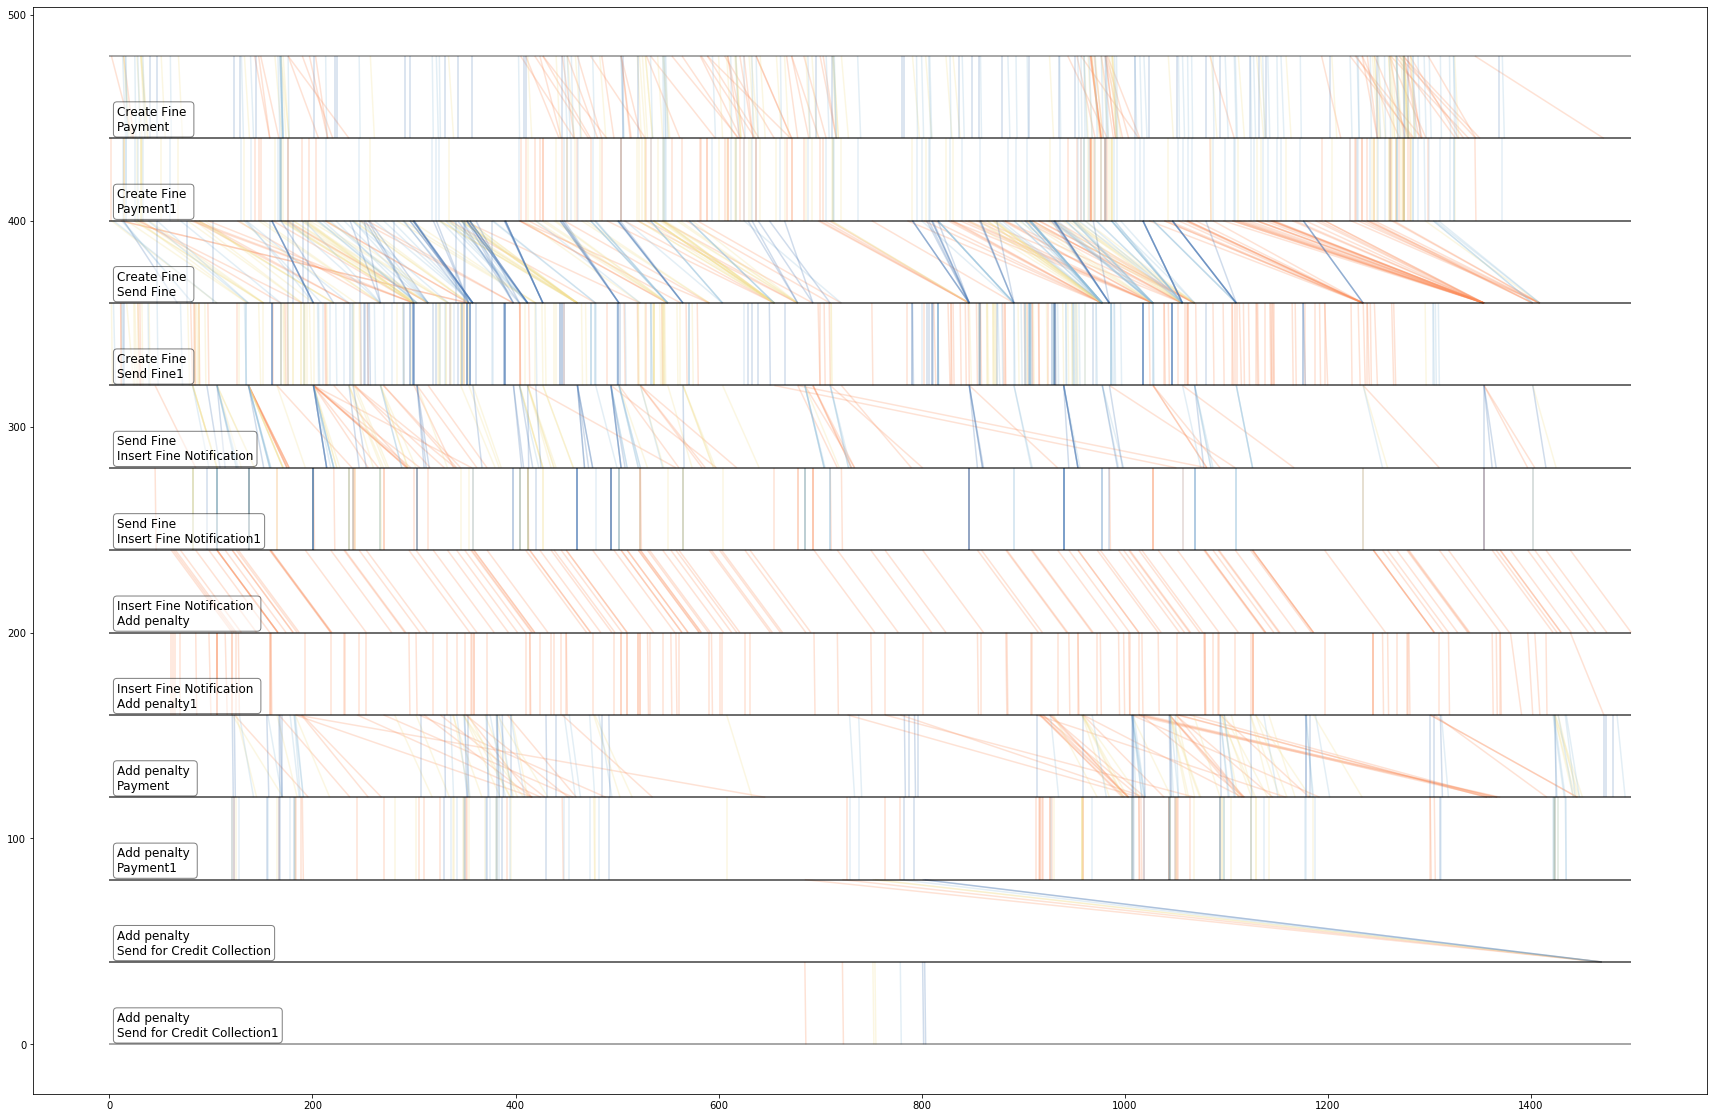

In [209]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
outlier_workers = list(dict(df.groupby('resource')['waiting_time'].sum().sort_values(ascending=False)).keys())[:1]
mask = (rf.pf['resource'].isin(outlier_workers))  & (rf.pf['class'] == 0) #& outliers
fig, ax = plt.subplots(figsize=[30,20])
rf.plot_performance_spectrum(class_colors, ax, mask=mask, compare='local', classifier=rf.classify_duration_hist, args=[4], metric='duration')

In [8]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
rf.pf['waiting_time'] = rf.pf['waiting_time'].fillna(0)
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=rf.pf['class']==0, metric='waiting_time', classifier=rf.classify_duration_hist, args=[4])

KeyError: 'waiting_time'

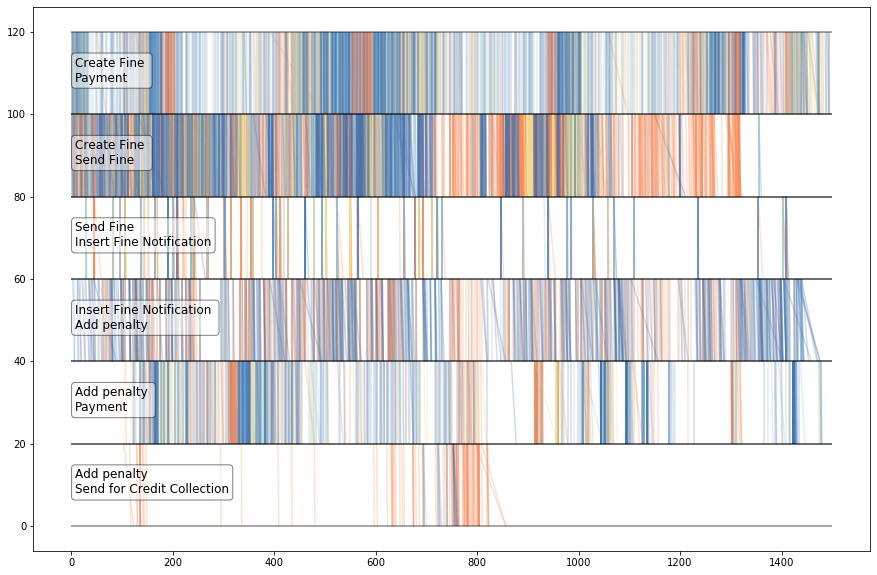

In [171]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=rf.pf['class']==0, end='correct_end', metric='waiting_time', classifier=rf.classify_duration_hist, args=[4])

In [166]:
# Using batch classifier to indicate if corrected trace was in a batch.
# This is because it is hard to see which traces where batched once the times have been adjusted.

# Sort per resource.
df = rf.classify(rf.pf, metric=['start_time', 'end_time'], classifier=rf.batch_classifier, args=[10,0,1])
df = rf.pf.sort_values(['resource','start_time', 'end_time'])
current = None
last_end = None
prev = None
corrected = {}
causes = {}
busy = {}
for ind, row in df.iterrows():
    if row['resource'] != current: # Switching to new resource. 
        current = row['resource']
        last_end = None
    if last_end is not None and last_end['end_time'] > row['start_time']:
        # The worker was busy during the start of this event, correcting.
        if ind not in busy:
            busy[ind] = [ind]
        else:
            busy[ind].append(ind)
        corrected[prev] = row['start_time']
        if last_end['class'] == 1:
            causes[prev] = 1  # Batch is cause.
        else:
            causes[prev] = 0  # No batch, but still a cause. 
    last_end = row
    prev = ind
    
df['busy'] = df.index.map(busy)
df['correct_end'] = df.index.map(corrected)
df['cause'] = df.index.map(causes)
df['batch'] = df['class']
rf.pf = df.sort_index()
rf.pf['waiting_time'] = rf.pf['end_time']-rf.pf['correct_end']
rf.pf['correct_duration'] = rf.pf['correct_end']-rf.pf['start_time']

In [68]:
# Outliers in waiting time (time on shelf) that where not in an end-batch.
outliers = ((rf.pf['waiting_time'] - rf.pf['waiting_time'].mean())/rf.pf['waiting_time'].std() > 1) 
outlier_workers = list(dict(rf.pf.groupby('resource')['waiting_time'].sum().sort_values(ascending=False)).keys())[:1]
mask = (rf.pf['resource'].isin(outlier_workers))  & (rf.pf['cause'] == 0) #& outliers

mask_busy = (~rf.pf['busy'].isna())&(rf.pf['resource'].isin(outlier_workers))
delayed = list(rf.pf[mask].index)
toplot = []
for ind, row in rf.pf[mask_busy].iterrows():
    for cause in row['busy']:
        if cause in delayed:
            if row['start_time'] != int(row['correct_end']):
                toplot.append([i for i in range(row['start_time'], int(row['correct_end'])+1)])
            else:
                toplot.append([row['start_time'], row['start_time']])
lines = [[(i[0],120), (i[1], 0)] for i in toplot]

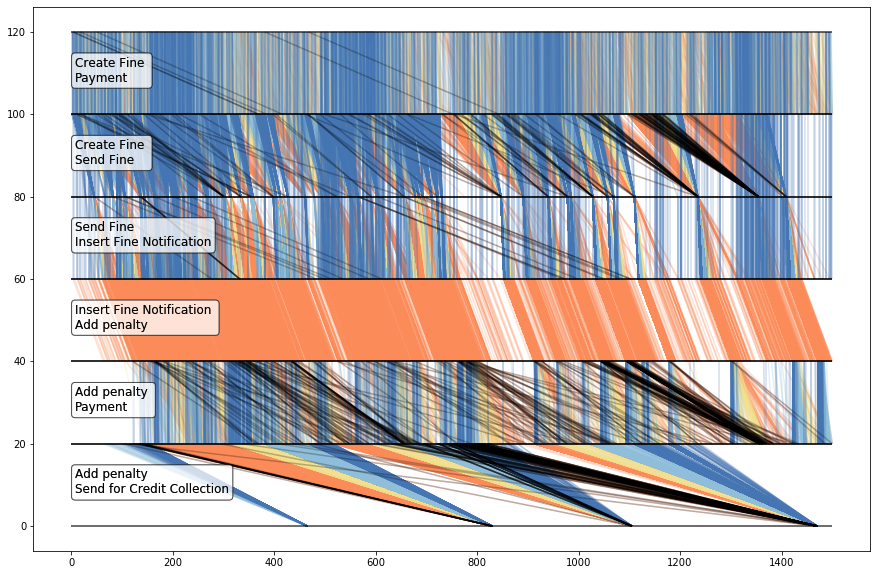

In [87]:
fig, ax = plt.subplots(figsize=[15,10])
# ax.add_collection(mc.LineCollection(lines, alpha=0.1))
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
rf.plot_performance_spectrum(class_colors, ax, metric='duration', classifier=rf.classify_duration_hist, args=[4])
class_colors = [(0.5,0.5,0.5), (0,0,0)]
rf.plot_performance_spectrum(class_colors, ax, mask=mask, vis_mask=True, show_classes=[1])

(array([   0,   28,   56,   84,  112,  140,  168,  196,  224,  252,  280,
         308,  336,  364,  392,  420,  448,  476,  504,  532,  560,  588,
         616,  644,  672,  700,  728,  756,  784,  812,  840,  868,  896,
         924,  952,  980, 1008, 1036, 1064, 1092, 1120, 1148, 1176, 1204,
        1232, 1260, 1288, 1316, 1344, 1372, 1400, 1428, 1456, 1484]),
 <a list of 54 Text xticklabel objects>)

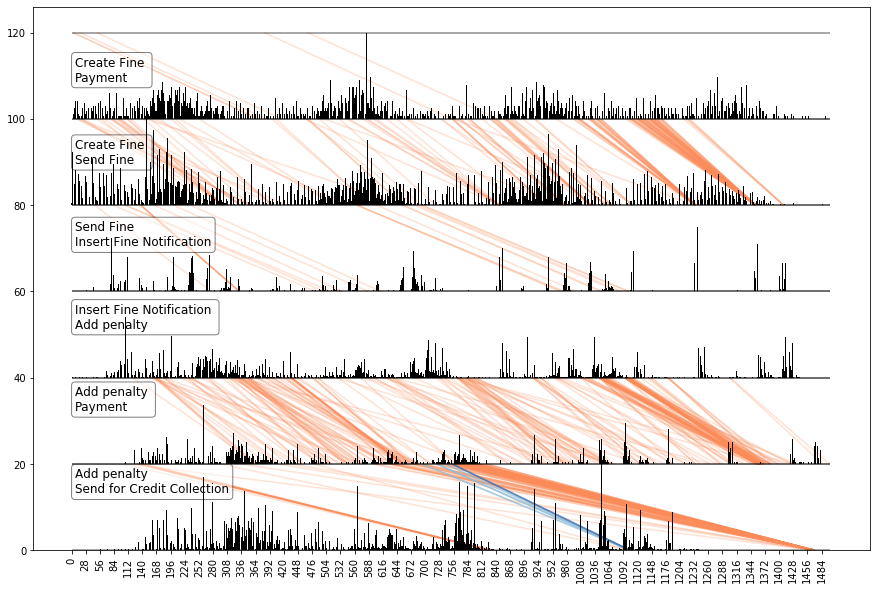

In [71]:
rf.pf['waiting_time'] = rf.pf['waiting_time'].fillna(0)
mask = (rf.pf['cause'] == 0) & ((rf.pf['waiting_time'] - rf.pf['waiting_time'].mean())/rf.pf['waiting_time'].std() > 0.5) 
resources = list(rf.pf[mask]['resource'].unique())
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=mask, metric='waiting_time', classifier=rf.classify_duration_hist, args=[4])
window=7
for s in range(len(segments)):
    df = rf.pf[(rf.pf['segment_index'] == s) & (rf.pf['resource'].isin(resources))]
    load_in_window = {i:[] for i in df['resource'].unique()}
    for i in range(0, max(df['end_time']), window):
        workload = dict(df[(df['start_time'] >= i) & (df['start_time'] <= i+window)].groupby('resource').count()['start_time'])
        for resource in df['resource'].unique():
            if resource in workload.keys():
                load_in_window[resource].append(workload[resource])
            else:
                load_in_window[resource].append(0)
    x, height = [],[]
    for k in range(len(load_in_window[list(load_in_window.keys())[0]])):
        load_per_time = list(pd.DataFrame(load_in_window).transpose()[k])
        x.extend([(k*7)+(window/len(load_per_time))*i for i in range(len(load_per_time))])
        height.extend([load for load in load_per_time])
    height = np.array(height)
    height = ((height-height.min()) / (height.max()-height.min())) * 20
    ax.bar(x,height, bottom=rf.y_s[s][1], color=(0,0,0),  zorder=10)
ax.set_xticks([i for i in range(0, rf.x_max, 28)])
plt.xticks(rotation=90)

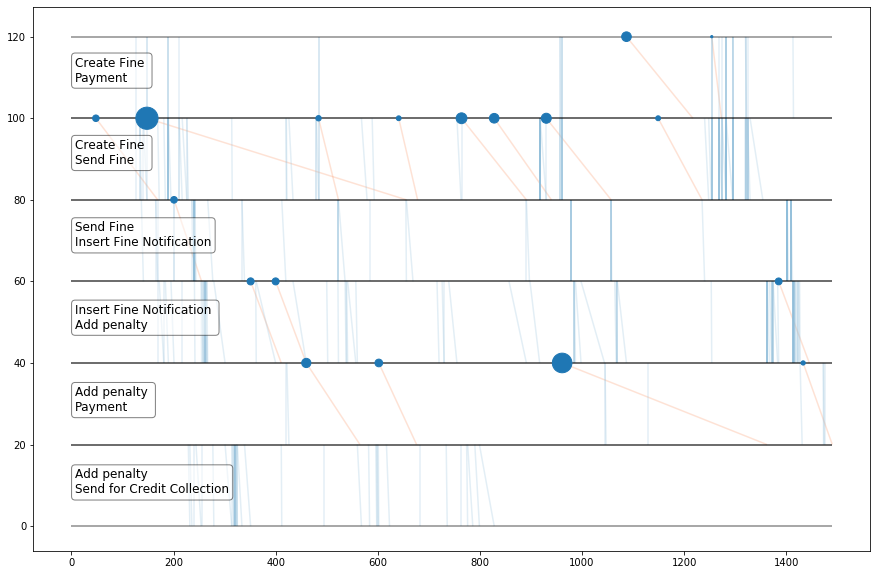

In [67]:
# Rebuilding the Performance Spectrum using corrected end time and corrected duration:
temp = copy.deepcopy(rf)
temp.build_coordinates(temp.pf['start_time'], temp.pf['correct_end'])
# rf.classify(metric='correct_duration', classifier=rf.classify_duration_hist, args=[4])
# mask = rf.pf['waiting_time'] > np.array(rf.pf.groupby('segment_index')['waiting_time'].mean()[rf.pf['segment_index']])
mask = ((rf.pf['correct_duration'] - rf.pf['correct_duration'].mean())/rf.pf['correct_duration'].std() > 3) & (rf.pf['batch'] == 0)
#mask = (rf.pf['class'] == 3) &   (rf.pf['batch'] == 0)
# rf.pf['class'] = 0
# for ind, row in rf.pf[mask].sort_values('waiting_time', ascending=False).head().iterrows():
#     # The lines that caused delay:
#     rf.pf.loc[mask & (rf.pf['start_time'] < row['end_time']) & (rf.pf['end_time'] > row['correct_end']) & (rf.pf['end_time'] < row['end_time']) & (row['resource'] == rf.pf['resource']), 'class'] = 1
#     if sum(mask & (rf.pf['start_time'] < row['end_time']) & (rf.pf['end_time'] > row['correct_end']) & (rf.pf['end_time'] < row['end_time']) & (row['resource'] == rf.pf['resource'])) != 0:
#         # The delayed segment:
#         rf.pf.loc[rf.pf.index == ind, 'class'] = 2


rf.pf.loc[mask&rf.pf['resource'].isin(most_delayed_resources), 'class'] = 3
rf.pf.loc[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask), 'class'] = 1
rf.build_coordinates(rf.pf['start_time'], rf.pf['end_time'])
rf.pf.loc[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask), 'start'] = temp.pf[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask)]['start']
rf.pf.loc[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask), 'end'] = temp.pf[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask)]['end']


most_delayed_resources = list(dict(rf.pf[~rf.pf['delayed'].isna()]['resource'].value_counts()[:1]).keys())
for ind, row in rf.pf[mask&rf.pf['resource'].isin(most_delayed_resources)].iterrows():
    # The lines that caused delay:
    rf.pf.loc[(rf.pf['start_time'] < row['end_time']) & (rf.pf['end_time'] > row['correct_end']) & (rf.pf['end_time'] < row['end_time']) & (row['resource'] == rf.pf['resource']), 'delayer'] = 1

        
fig, ax = plt.subplots(figsize=[15,10])
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
rf.plot_performance_spectrum(class_colors, ax, mask=(mask&rf.pf['resource'].isin(most_delayed_resources))|((rf.pf['resource'].isin(most_delayed_resources)) & (~mask) & (rf.pf['delayer'] == 1)))


# Adding a scatter plot with the waiting time for traces.
ax.scatter(rf.pf[mask&rf.pf['resource'].isin(most_delayed_resources)]['start_time'], rf.pf[mask&rf.pf['resource'].isin(most_delayed_resources)]['start_y'], s=rf.pf[mask&rf.pf['resource'].isin(most_delayed_resources)]['waiting_time'], zorder=10)

(array([   0,   28,   56,   84,  112,  140,  168,  196,  224,  252,  280,
         308,  336,  364,  392,  420,  448,  476,  504,  532,  560,  588,
         616,  644,  672,  700,  728,  756,  784,  812,  840,  868,  896,
         924,  952,  980, 1008, 1036, 1064, 1092, 1120, 1148, 1176, 1204,
        1232, 1260, 1288, 1316, 1344, 1372, 1400, 1428, 1456, 1484]),
 <a list of 54 Text xticklabel objects>)

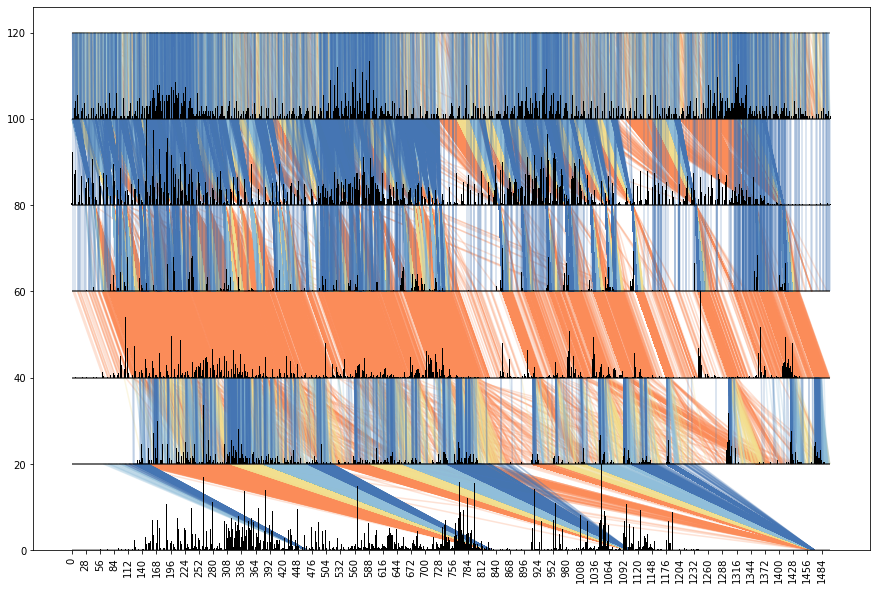

In [19]:
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax)
window=7
for s in range(len(segments)):
    df = rf.pf[rf.pf['segment_index'] == s]
    load_in_window = {i:[] for i in df['resource'].unique()}
    for i in range(0, max(df['end_time']), window):
        workload = dict(df[(df['start_time'] >= i) & (df['start_time'] <= i+window)].groupby('resource').count()['start_time'])
        for resource in df['resource'].unique():
            if resource in workload.keys():
                load_in_window[resource].append(workload[resource])
            else:
                load_in_window[resource].append(0)
    x, height = [],[]
    for k in range(len(load_in_window[list(load_in_window.keys())[0]])):
        load_per_time = list(pd.DataFrame(load_in_window).transpose()[k])
        x.extend([(k*7)+(window/len(load_per_time))*i for i in range(len(load_per_time))])
        height.extend([load for load in load_per_time])
    height = np.array(height)
    height = ((height-height.min()) / (height.max()-height.min())) * 20
    ax.bar(x,height, bottom=rf.y_s[s][1], color=(0,0,0),  zorder=10)
ax.set_xticks([i for i in range(0, rf.x_max, 28)])
plt.xticks(rotation=90)

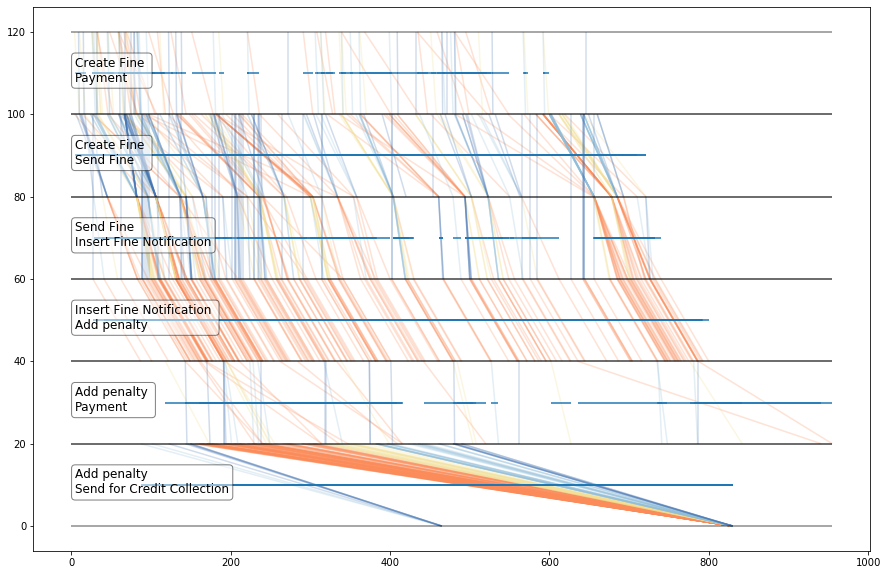

In [252]:
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=(rf.pf['end_time'] <= 1000) & (rf.pf['resource'] == '27'))

y_s = [i for i in range(110, 0, -20)]
lines = []
for ind, data in rf.pf[rf.pf['resource'] == '27'].iterrows():
    if data['end_time'] <= 1000:
        line = [(data['start_time'], y_s[data['segment_index']]), (data['end_time'], y_s[data['segment_index']])]
        lines.append(line)
    
ax.add_collection(mc.LineCollection(lines))

In [11]:
workloads = []
for segment in range(len(segments)):
    mask = rf.pf['segment_index'] == segment

    working_times = {}
    for ind, data in rf.pf[mask].iterrows():
        if data['resource'] not in working_times:
            working_times[data['resource']] = [[data['start_time'], data['end_time']]]
        else:
            if data['start_time'] <= working_times[data['resource']][-1][-1]:
                # A resource was already working on something:
                if data['end_time'] > working_times[data['resource']][-1][-1]:
                    # Extending the known working time:
                    working_times[data['resource']][-1][-1] = data['end_time']
            else:
                working_times[data['resource']].append([data['start_time'], data['end_time']])

    workload = {}
    for resource in working_times:
        total = working_times[resource][-1][-1] - working_times[resource][0][0]
        if total == 0:
            workload[resource] = 0
        else:
            worked = sum((working_times[resource][i][1] - working_times[resource][i][0]) for i in range(len(working_times[resource])))
            workload[resource] = worked/total
    workloads.append(workload)

In [9]:
resources = rf.pf['resource'].unique()
load_df = pd.DataFrame(index=resources)
for workload,i in zip(workloads, range(len(segments))):
    for resource in resources:
        if resource not in workload.keys():
            workload[resource] = 0
    load_df['workload at ' + str(i)] = workload.values()

In [10]:
for i in range(len(segments)):
    load_df['mean duration at ' + str(i)] = rf.pf[rf.pf['segment_index'] == i].groupby('resource')['duration'].mean()

In [15]:
log = importer.apply('C:/Users/20173939/Documents/Study/BEP/BPIC15_2.xes.xml')
rf = BEP_PM.EventLog('BPI15', 'concept:name', 'time:timestamp', log)
rf.clean_timezone()
rf.save()

In [16]:
rf = BEP_PM.EventLog('BPI15', 'concept:name', 'time:timestamp')
rf.count_trace_types()

{('01_HOOFD_010', '01_HOOFD_810'): 180,
 ('01_HOOFD_010', '01_HOOFD_820'): 196,
 ('01_HOOFD_010', '01_HOOFD_520'): 9,
 ('01_HOOFD_010', '01_HOOFD_530'): 15,
 ('01_HOOFD_010', '01_HOOFD_805'): 5,
 ('01_HOOFD_010', '01_HOOFD_195'): 2,
 ('01_HOOFD_030_2', '01_HOOFD_820'): 13,
 ('01_HOOFD_010', '01_HOOFD_101'): 4,
 ('01_HOOFD_010', '01_BB_770'): 94,
 ('01_HOOFD_010', '01_HOOFD_065_2'): 1,
 ('01_HOOFD_010', '01_BB_775'): 3,
 ('01_HOOFD_010', '01_HOOFD_516'): 3,
 ('01_HOOFD_010', '01_HOOFD_061'): 3,
 ('01_HOOFD_010', '08_AWB45_090_3'): 2,
 ('01_HOOFD_065_2', '01_HOOFD_516'): 1,
 ('01_HOOFD_010', '01_HOOFD_015'): 4,
 ('01_HOOFD_030_2', '01_HOOFD_195'): 1,
 ('01_HOOFD_010', '01_HOOFD_519'): 3,
 ('01_HOOFD_010', '14_VRIJ_060_3'): 1,
 ('01_HOOFD_010', '01_BB_705'): 1,
 ('01_HOOFD_010', '08_AWB45_025'): 5,
 ('01_HOOFD_010', '02_DRZ_010'): 1,
 ('01_HOOFD_010', '01_HOOFD_815'): 2,
 ('01_HOOFD_010', '01_HOOFD_101b'): 2,
 ('01_HOOFD_010', '16_LGSV_010'): 2,
 ('01_HOOFD_010', '01_HOOFD_250_2'): 1,
 ('

In [17]:
segments = rf.filter_segments(0.50, compare_to='first')

In [18]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]

rf.performance_spectrum(segments, x_max=int(5 * 365), metric='duration', classifier=rf.classify_duration_hist, args=[4])

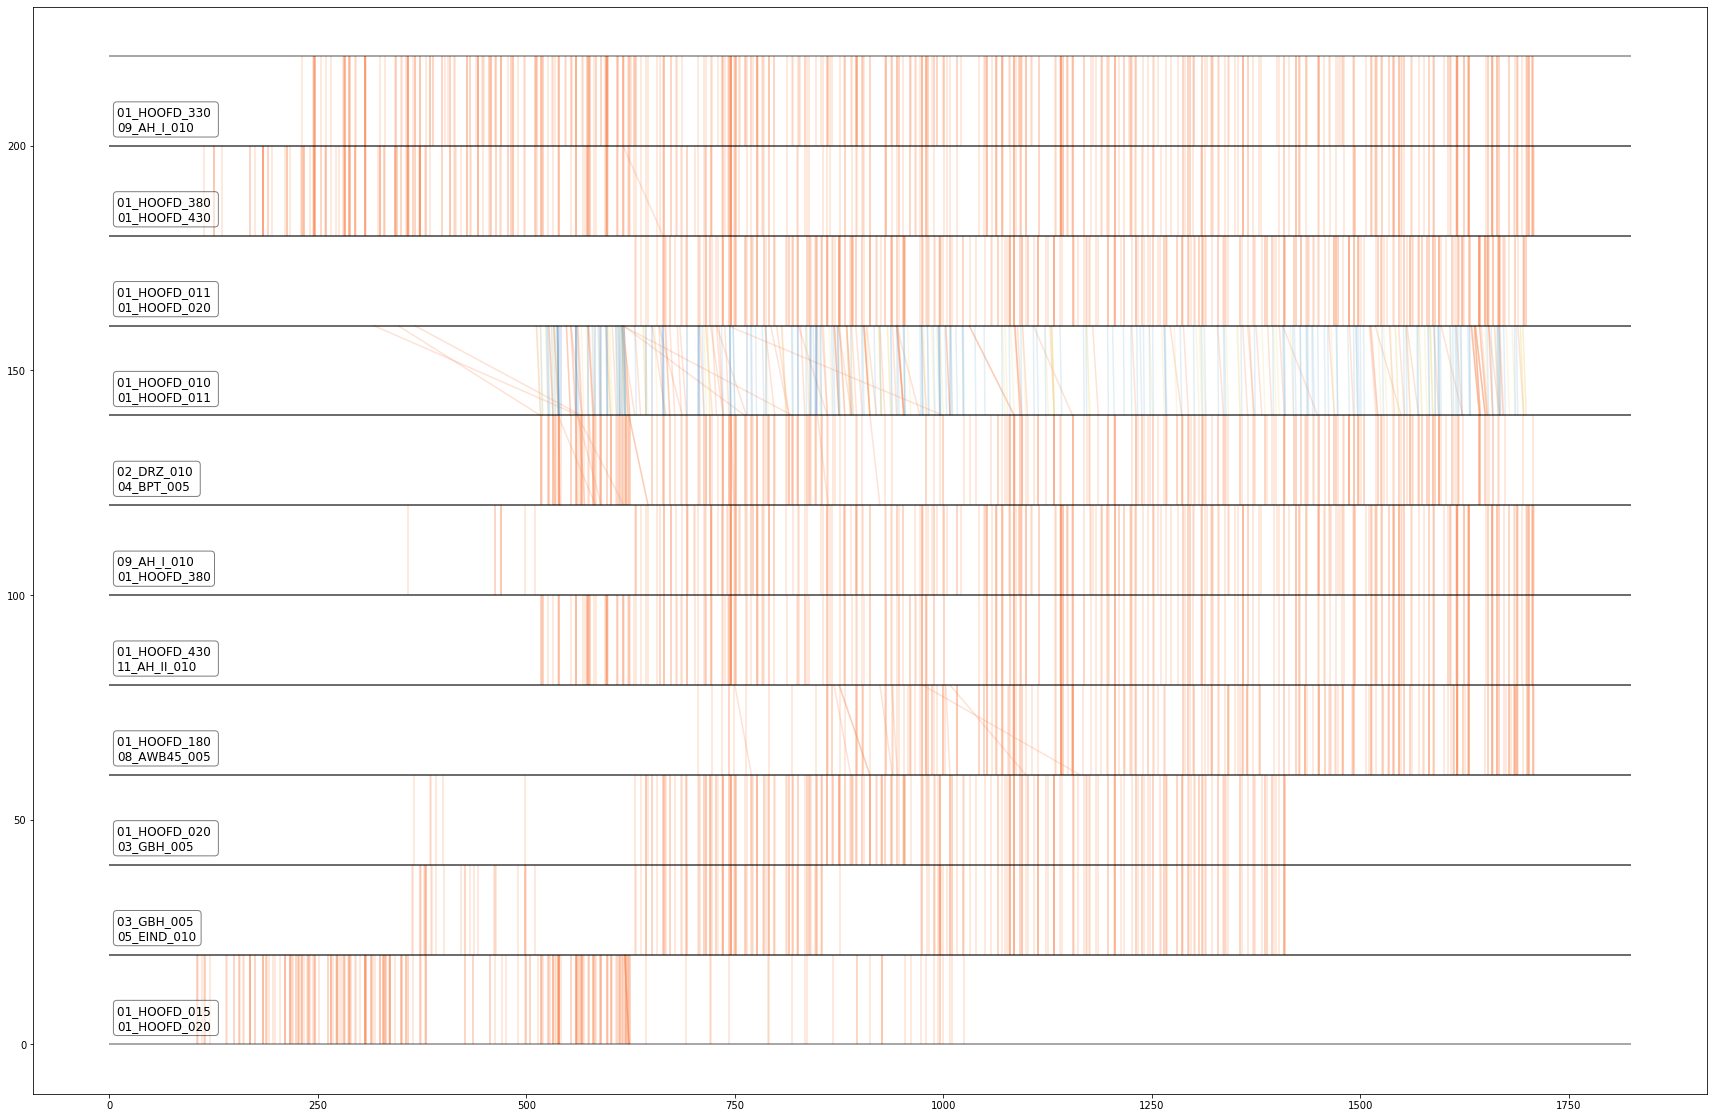

In [20]:
rf.plot_performance_spectrum(class_colors)

In [3]:
log = importer.apply('C:/Users/20173939/Documents/Study/BEP/BPI Challenge 2017.xes')

In [5]:
log[0][0]

{'Action': 'Created', 'org:resource': 'User_1', 'concept:name': 'A_Create Application', 'EventOrigin': 'Application', 'EventID': 'Application_652823628', 'lifecycle:transition': 'complete'}

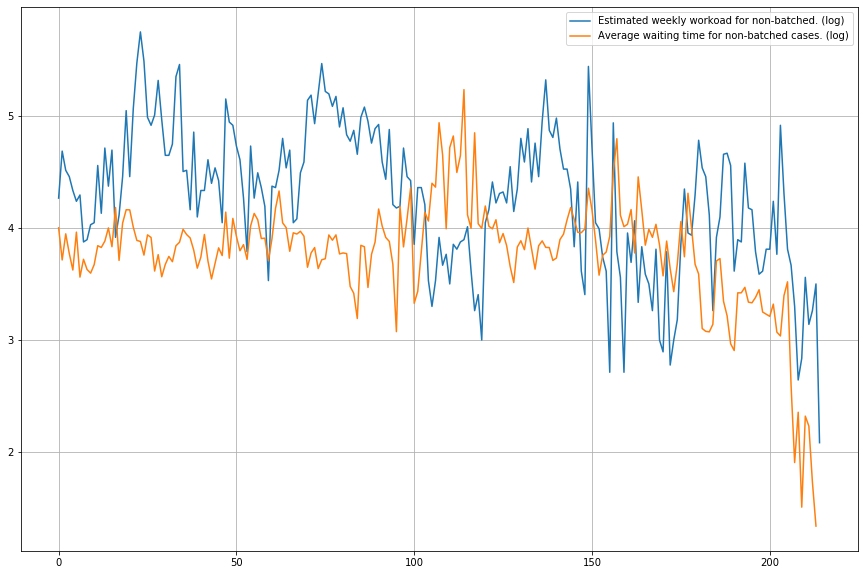

In [145]:
df = rf.pf.sort_values('start_time').copy()
x1 = np.array([list(df[(df['start_time'] >= i)&(df['start_time'] <= i+7) & (df['batch']==0)].count())[0] for i in range(0, df['start_time'].max(), 7)])
x2 = np.array([df[(df['start_time'] >= i)&(df['start_time'] <= i+7)&(df['cause'] == 0) ]['waiting_time'].mean() for i in range(0, df['start_time'].max(), 7)])
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(np.log(x1+1), label='Estimated weekly workoad for non-batched. (log)')
ax.plot(np.log(x2+1), label='Average waiting time for non-batched cases. (log)')
ax.legend()
ax.grid()

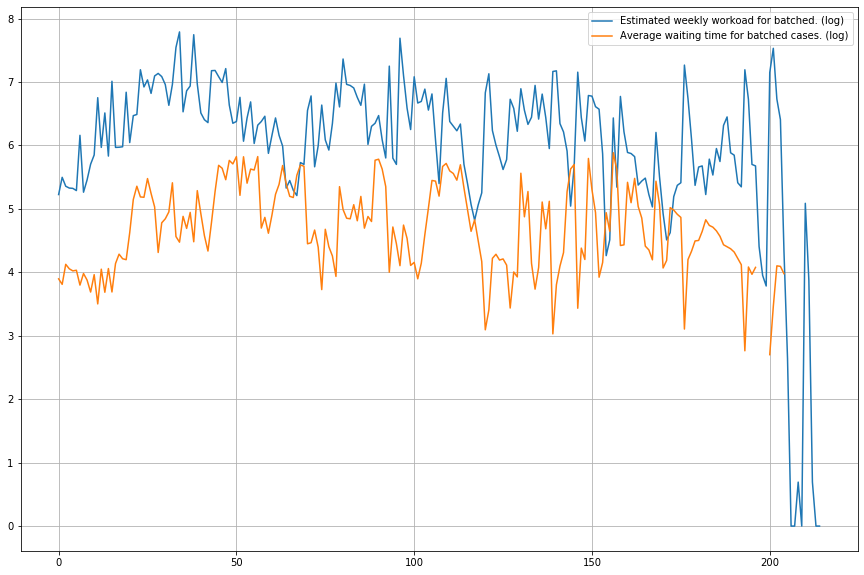

In [146]:
df = rf.pf.sort_values('start_time').copy()
x1 = np.array([list(df[(df['start_time'] >= i)&(df['start_time'] <= i+7) & (df['batch']>0)].count())[0] for i in range(0, df['start_time'].max(), 7)])
x2 = np.array([df[(df['start_time'] >= i)&(df['start_time'] <= i+7)&(df['cause'] == 1) ]['waiting_time'].mean() for i in range(0, df['start_time'].max(), 7)])
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(np.log(x1+1), label='Estimated weekly workoad for batched. (log)')
ax.plot(np.log(x2+1), label='Average waiting time for batched cases. (log)')
ax.legend()
ax.grid()

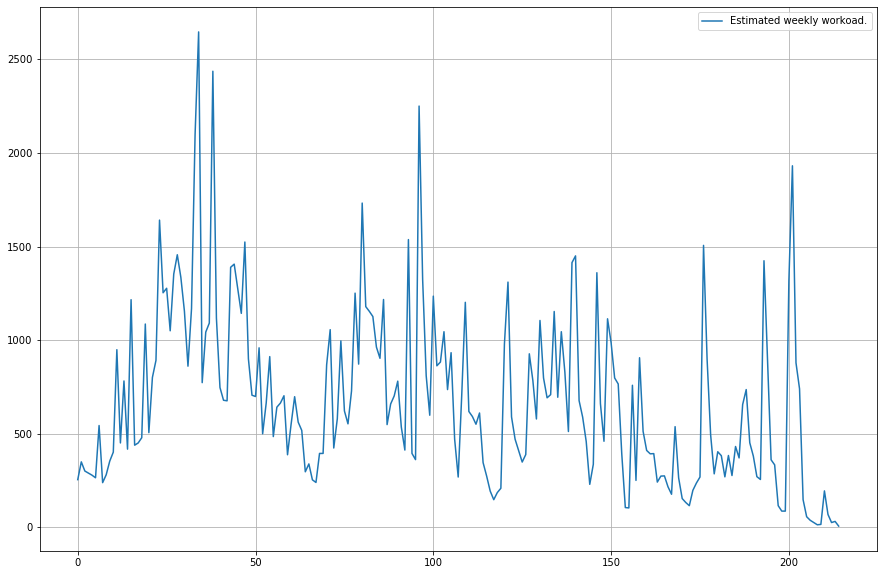

In [151]:
outlier = df['waiting_time'].mean()+df['waiting_time'].std()
df = rf.pf.sort_values('start_time').copy()
x1 = np.array([list(df[(df['start_time'] >= i)&(df['start_time'] <= i+7)].count())[0] for i in range(0, df['start_time'].max(), 7)])
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(x1, label='Estimated weekly workoad.')
ax.legend()
ax.grid()

In [153]:
log = importer.apply('C:/Users/20173939/Documents/Study/BEP/BPI Challenge 2017.xes/BPI Challenge 2017.xes',[True])
bpi = BEP_PM.EventLog('BPI2017', 'concept:name', 'time:timestamp', log, resource_id='org:resource')

In [154]:
pf = pd.concat([pd.DataFrame(log[i]) for i in range(len(log))])

In [155]:
pf.loc[pf.index == 0, 'case_id'] = [i for i in range((pf.index == 0).sum())]

In [156]:
pf['case_id'] = pf['case_id'].fillna(method='ffill')

In [157]:
pf.sort_values(["case_id", "concept:name", "time:timestamp"], inplace=True)

In [158]:
df = pf[['case_id', "concept:name", "lifecycle:transition","org:resource","time:timestamp"]]

In [159]:
segment_cycles = dict(df.groupby('concept:name')['lifecycle:transition'].value_counts())
cycles_per_segments = {}
for concept in df['concept:name'].unique():
    cycles_per_segments[concept] = [segment[1] for segment in segment_cycles if concept in segment[0]]
detailed = [segment for segment in cycles_per_segments if len(cycles_per_segments[segment]) > 1]

In [160]:
detailed

['W_Call after offers',
 'W_Call incomplete files',
 'W_Complete application',
 'W_Handle leads',
 'W_Validate application',
 'W_Assess potential fraud',
 'W_Personal Loan collection',
 'W_Shortened completion ']

In [161]:
t_org = df[(df['concept:name'].isin(detailed))]
{life_cycle:list(t.shift()[(t['lifecycle:transition'] == life_cycle) & (t['case_id'] == t.shift()['case_id']) & (t['concept:name'] == t.shift()['concept:name'])]['lifecycle:transition'].unique()) for life_cycle in t['lifecycle:transition'].unique()}

{'schedule': ['ate_abort', 'complete', 'withdraw'],
 'start': ['schedule', 'resume', 'start'],
 'suspend': ['start', 'resume', 'suspend'],
 'resume': ['suspend'],
 'ate_abort': ['suspend'],
 'withdraw': ['schedule'],
 'complete': ['resume', 'start']}

In [162]:
wierd = t[(t['lifecycle:transition'] == 'schedule') & (t.shift()['lifecycle:transition'] == 'complete') & (t['case_id'] == t.shift()['case_id']) & (t['concept:name'] == t.shift()['concept:name'])].append(t.shift()[(t['lifecycle:transition'] == 'schedule') & (t.shift()['lifecycle:transition'] == 'complete') & (t['case_id'] == t.shift()['case_id']) & (t['concept:name'] == t.shift()['concept:name'])])

In [163]:
wierd.sort_values(['case_id', 'time:timestamp'])

case_id            concept:name lifecycle:transition org:resource  \
132         3.0  W_Validate application             complete      User_95   
132         3.0  W_Validate application             schedule     User_116   
372        14.0  W_Validate application             complete      User_87   
372        14.0  W_Validate application             schedule     User_116   
667        30.0  W_Validate application             complete      User_29   
...         ...                     ...                  ...          ...   
768562  31498.0  W_Validate application             schedule      User_41   
768643  31501.0  W_Validate application             complete      User_53   
768643  31501.0  W_Validate application             schedule     User_123   
768771  31506.0  W_Validate application             complete      User_31   
768771  31506.0  W_Validate application             schedule       User_2   

                time:timestamp  
132    2016-01-28 09:18:39.340  
132    2016-01-28 11:56:13.865  
372    2016-01-12 08:31:24.097  
372    2016-01-12 10:58:18.763  
667    2016-01-22 09:38:51.012  
...                        ...  
768562 2017-01-16 17:39:43.735  
768643 2017-01-11 14:26:39.529  
768643 2017-01-13 10:30:50.136  
768771 2017-01-13 10:19:21.180  
768771 2017-01-13 15:48:03.628  

[19394 rows x 5 columns]

In [263]:
t_org = df[(df['concept:name'].isin(detailed))].sort_values('time:timestamp').reset_index(drop=True)
t = t_org.sort_values(['case_id', 'concept:name', 'time:timestamp'])
c_total = pd.DataFrame()

for cid in t['case_id'].unique()[:500]:
    c = t[t['case_id'] == cid]
    starts = c['concept:name'].unique()
    prev = [c[c['concept:name']  == starts[i]].iloc[0].name for i in range(len(starts))]

    c_prev = pd.concat([pd.DataFrame(t_org.loc[i-1:i].values.flatten()).T for i in prev if i-1 >= 0])

    c_t = pd.concat([c, c.shift(-1)], axis=1)
    c_t.columns = ['case_id', "concept:name", "lifecycle:transition", "org:resource","time:timestamp", 'case_id_end', "concept:name_end", "lifecycle:transition_end", "org:resource_end","time:timestamp_end"]
    c_t = c_t[c_t['concept:name'] == c_t['concept:name_end']]
    c_prev.columns = ['case_id', "concept:name", "lifecycle:transition", "org:resource","time:timestamp", 'case_id_end', "concept:name_end", "lifecycle:transition_end", "org:resource_end","time:timestamp_end"]
    c_t = c_t.append(c_prev)
    c_total = c_total.append(c_t)

In [264]:
c_total['segment_name'] = c_total['concept:name'] + "-" + c_total['lifecycle:transition'] + '\n'  +c_total['concept:name_end'] +"-" + c_total['lifecycle:transition_end']
c_total['resource'] = [(r1, r2) if r1 != r2 else r1 for r1, r2 in zip(c_total["org:resource"], c_total["org:resource_end"])]
c_total['case_id'] = [(id1, id2) if id1 != id2 else id1 for id1, id2 in zip(c_total["case_id"], c_total["case_id_end"])]

In [265]:
c_total = c_total.drop(labels=["concept:name", "concept:name_end","lifecycle:transition", "org:resource", 'case_id_end', "lifecycle:transition_end", "org:resource_end"], axis=1)
c_total.columns = ['case_id','start_time', 'end_time', 'segment_name', 'resource']

In [266]:
cutoff = 0.5

segment_counts = dict(c_total['segment_name'].value_counts())
max_i = list(segment_counts.keys())[0]

per_segment_counts = {}
for i in segment_counts.keys():
    if i.split('\n')[0] in per_segment_counts:
        per_segment_counts[i.split('\n')[0]] += segment_counts[i]
    else:
        per_segment_counts[i.split('\n')[0]] = segment_counts[i]
        
max_i = list(per_segment_counts.keys())[0]
segments_toplot = [i for i in per_segment_counts if per_segment_counts[i] / per_segment_counts[max_i] >= cutoff]
segments = sorted([i for i in segment_counts.keys() if i.split('\n')[0] in segments_toplot], reverse=True)

In [267]:
c_total['start_time'] = c_total['start_time'] - bpi.first
c_total['end_time'] = c_total['end_time'] - bpi.first
c_total['start_time']  = c_total['start_time'].dt.days*24 + round(c_total['start_time'].dt.seconds/3600)
c_total['end_time']  = c_total['end_time'].dt.days*24 + round(c_total['end_time'].dt.seconds/3600)
c_total['duration'] = c_total['end_time'] - c_total['start_time']

In [268]:
c_total['segment_index'] = c_total['segment_name'].apply(lambda x: list(segment_counts.keys()).index(x))
c_total['start_y'] = (200//len(segments))*(len(segments)-c_total['segment_index'])
c_total['end_y'] = c_total['start_y'] - (200//len(segments))
bpi.pf = c_total
bpi.segments = segments
bpi.y_s = [[y, y - (200//len(segments))] for y in range((200//len(segments)) * len(segments), 0, -(200//len(segments)))]

bpi.classify(bpi.pf, bpi.classify_duration_hist, args=[4], metric='duration', inplace=True)

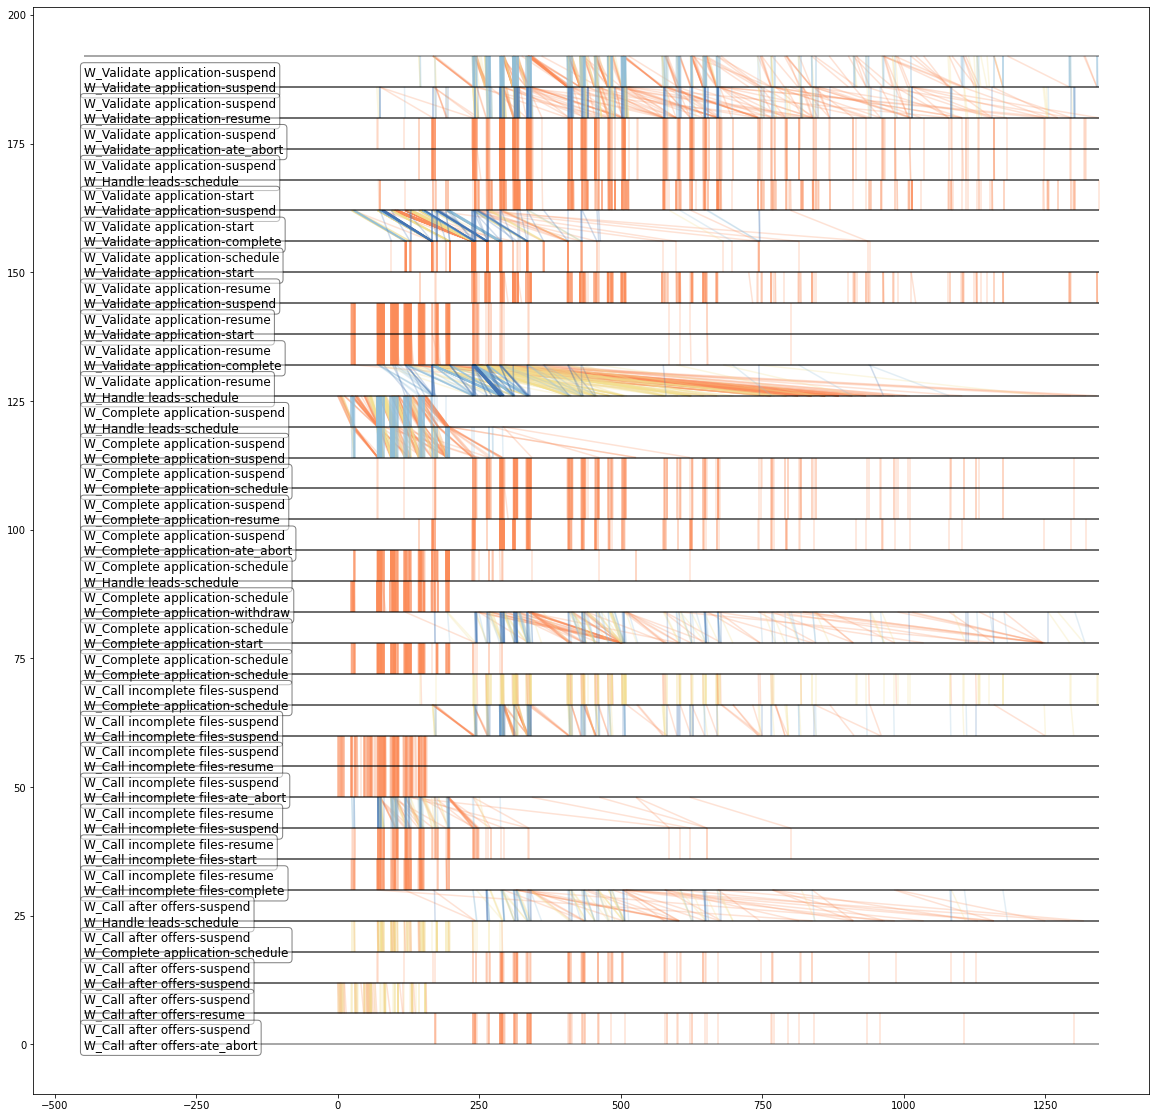

In [269]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
fig, ax = plt.subplots(figsize=[20,20])
bpi.plot_performance_spectrum(class_colors, ax, mask=bpi.pf['end_time'] <= 8*7*24)

# Figuring out the overall transitions (without lifecycle)

In [208]:
df = df.sort_values(['case_id', 'time:timestamp'])
# pd.concat([df[df['case_id'] == 3725.0], df.shift(-1)[df['case_id'] == 3725.0]], axis=1)

In [214]:
case = df[df['case_id'] == 1].groupby('concept:name').first().reset_index().append(df[df['case_id'] == 1].groupby('concept:name').last().reset_index())
case = case.drop_duplicates().sort_values('time:timestamp')
case = pd.concat([case, case.shift(-1)], axis=1)


######
done = []
cols = []
for col in case.columns:
    cols.append('start_' + col if col not in done else 'end_' + col)
    done.append(col)
case.columns = cols

In [15]:
filtered = df[(df['concept:name'].isin(detailed))].sort_values(['case_id', 'time:timestamp'])
start_times = []
end_times = []
concept_names = []
case_id = []
resource = []
for name, segment in filtered.groupby(['case_id', 'concept:name']):
    for i in range(len(segment)):
        if segment.iloc[i]['lifecycle:transition'] == 'start' or segment.iloc[i]['lifecycle:transition'] == 'resume':
            start_times.append(segment.iloc[i]['time:timestamp'])
            end_times.append(segment.iloc[i+1]['time:timestamp'])
            resource.append(segment.iloc[i]['org:resource'])
            case_id.append(name[0])
            if segment.iloc[i+1]['lifecycle:transition'] == 'complete':
                concept_names.append(segment.iloc[i]['concept:name'] + "\n start/resume work \u2192 completed")
                # We are done with this segment.
                break
            else:
                concept_names.append(segment.iloc[i]['concept:name'] + "\n start/resume work \u2192 shelved")
        elif segment.iloc[i]['lifecycle:transition'] == 'ate_abort':
            start_times.append(segment.iloc[i-1]['time:timestamp'])
            end_times.append(segment.iloc[i]['time:timestamp'])
            resource.append(segment.iloc[i]['org:resource'])
            concept_names.append(segment.iloc[i]['concept:name'] + "\n shelved \u2192 abborted")
            case_id.append(name[0])
        elif i == len(segment) - 1:
            # The case does not have an end, its suspended forever.
            print(name)
        elif segment.iloc[i]['lifecycle:transition'] == 'suspend' and segment.iloc[i+1]['lifecycle:transition'] == 'resume':
            start_times.append(segment.iloc[i]['time:timestamp'])
            end_times.append(segment.iloc[i+1]['time:timestamp'])
            resource.append((segment.iloc[i]['org:resource'], segment.iloc[i+1]['org:resource']))
            concept_names.append(segment.iloc[i]['concept:name'] + "\n shelved \u2192 resumed")
            case_id.append(name[0])

(2462.0, 'W_Personal Loan collection')
(8492.0, 'W_Personal Loan collection')
(14292.0, 'W_Shortened completion ')
(14374.0, 'W_Shortened completion ')
(14489.0, 'W_Shortened completion ')
(14490.0, 'W_Shortened completion ')
(14507.0, 'W_Shortened completion ')
(14511.0, 'W_Shortened completion ')
(14518.0, 'W_Shortened completion ')
(14523.0, 'W_Shortened completion ')
(14531.0, 'W_Shortened completion ')
(14538.0, 'W_Shortened completion ')
(14540.0, 'W_Shortened completion ')
(14547.0, 'W_Shortened completion ')
(14550.0, 'W_Shortened completion ')
(14554.0, 'W_Shortened completion ')
(14555.0, 'W_Shortened completion ')
(14558.0, 'W_Shortened completion ')
(14559.0, 'W_Shortened completion ')
(14561.0, 'W_Shortened completion ')
(14571.0, 'W_Shortened completion ')
(14575.0, 'W_Shortened completion ')
(14581.0, 'W_Shortened completion ')
(14583.0, 'W_Shortened completion ')
(14585.0, 'W_Shortened completion ')
(14587.0, 'W_Shortened completion ')
(14617.0, 'W_Shortened completion 

In [16]:
split_pf = pd.DataFrame()
split_pf['resource'] = resource
split_pf['start_time'] = start_times
split_pf['end_time'] = end_times
# self.pf['duration'] = duration
split_pf['segment_name'] = concept_names
# self.pf['segment_index'] = segment_index
split_pf['case_id'] = case_id

df = split_pf
cutoff = 0.1

segment_counts = dict(df['segment_name'].value_counts())
max_i = list(segment_counts.keys())[0]

per_segment_counts = {}
for i in segment_counts.keys():
    if i.split('\n')[0] in per_segment_counts:
        per_segment_counts[i.split('\n')[0]] += segment_counts[i]
    else:
        per_segment_counts[i.split('\n')[0]] = segment_counts[i]
        
max_i = list(per_segment_counts.keys())[0]
segments_toplot = [i for i in per_segment_counts if per_segment_counts[i] / per_segment_counts[max_i] >= cutoff]
segments = sorted([i for i in segment_counts.keys() if i.split('\n')[0] in segments_toplot], reverse=True)

In [17]:
# df = pd.concat([df.groupby(['case_id', 'concept:name']).first(), df.groupby(['case_id', 'concept:name']).last()], axis=1)
# df = df.reset_index()
# df.columns = ['case_id', 'segment_name', 'start_lifecyle', 'start_resource', 'start_time', 'end_lifecyle', 'end_resource', 'end_time']
# df = df[df['start_lifecyle'] == 'start'].reset_index(drop=True)
# cutoff = 0.1
# segment_counts = dict(df['segment_name'].value_counts())
# max_i = list(segment_counts.keys())[0]
# segments = [i for i in segment_counts if segment_counts[i] / segment_counts[max_i] >= cutoff]
# df = df[df['segment_name'].isin(segments)]

In [18]:
segments

['W_Validate application\n start/resume work → shelved',
 'W_Validate application\n start/resume work → completed',
 'W_Validate application\n shelved → resumed',
 'W_Validate application\n shelved → abborted',
 'W_Complete application\n start/resume work → shelved',
 'W_Complete application\n start/resume work → completed',
 'W_Complete application\n shelved → resumed',
 'W_Complete application\n shelved → abborted',
 'W_Call incomplete files\n start/resume work → shelved',
 'W_Call incomplete files\n start/resume work → completed',
 'W_Call incomplete files\n shelved → resumed',
 'W_Call incomplete files\n shelved → abborted',
 'W_Call after offers\n start/resume work → shelved',
 'W_Call after offers\n start/resume work → completed',
 'W_Call after offers\n shelved → resumed',
 'W_Call after offers\n shelved → abborted']

In [19]:
df['start_time'] = df['start_time'] - bpi.first
df['end_time'] = df['end_time'] - bpi.first
df['start_time']  = df['start_time'].dt.days*24 + round(df['start_time'].dt.seconds/3600)
df['end_time']  = df['end_time'].dt.days*24 + round(df['end_time'].dt.seconds/3600)
df['duration'] = df['end_time'] - df['start_time']

In [20]:
df['segment_index'] = df['segment_name'].apply(lambda x: list(segment_counts.keys()).index(x))

In [21]:
df['start_y'] = (200//len(segments))*(len(segments)-df['segment_index'])

In [22]:
df['end_y'] = df['start_y'] - (200//len(segments))

In [23]:
bpi.pf = df
bpi.segments = segments

In [24]:
bpi.y_s = [[y, y - (200//len(segments))] for y in range((200//len(segments)) * len(segments), 0, -(200//len(segments)))]

In [25]:
# bpi = BEP_PM.EventLog('BPI2017', 'concept:name', 'time:timestamp', resource_id='org:resource')

In [26]:
bpi.classify(bpi.pf, bpi.classify_duration_hist, args=[4], metric='duration', inplace=True)

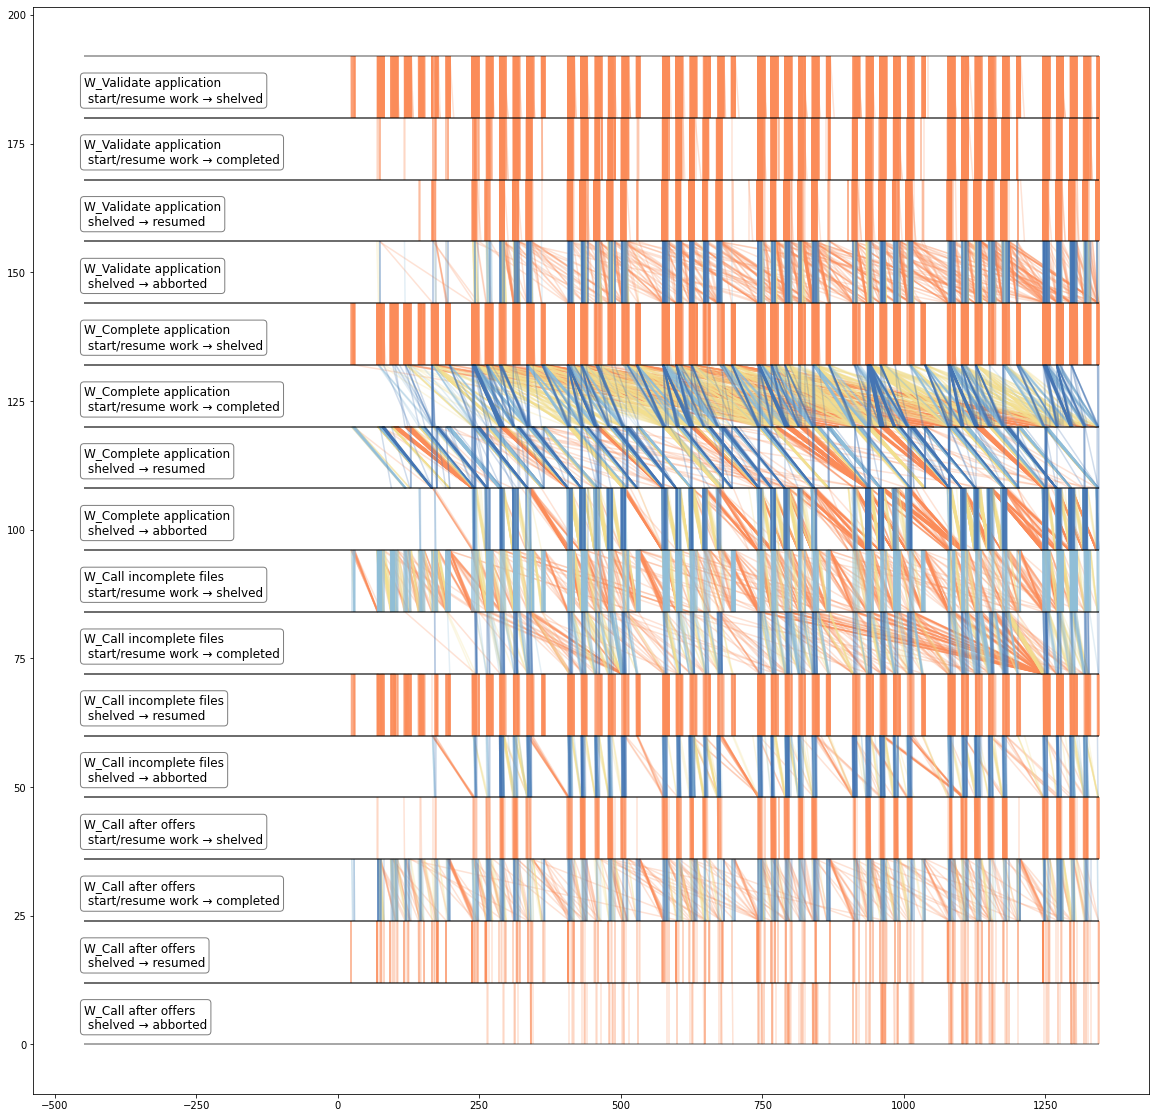

In [27]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
fig, ax = plt.subplots(figsize=[20,20])
bpi.plot_performance_spectrum(class_colors, ax, mask=bpi.pf['end_time'] <= 8*7*24)

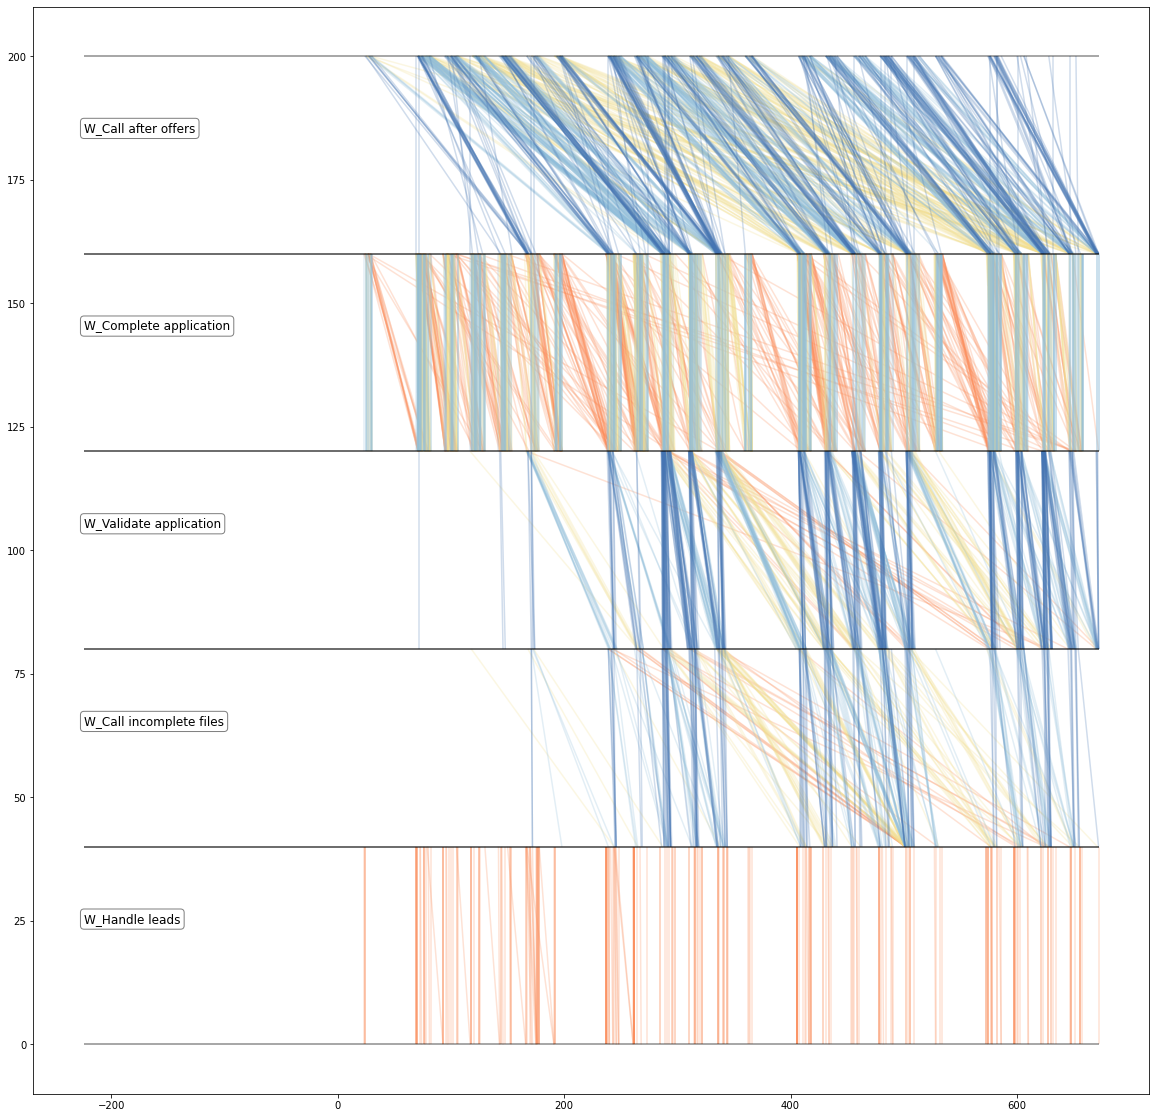

In [386]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
fig, ax = plt.subplots(figsize=[20,20])
bpi.plot_performance_spectrum(class_colors, ax, mask=bpi.pf['end_time'] <= 4*7*24)

In [60]:
df = bpi.pf.sort_values(['case_id', 'start_time'])
prev = df.iloc[0]
waiting_segments = []
k = 0
for ind, row in df.iterrows():
    if k != 0: # We skip the first.
        if prev['case_id'] != row['case_id']: # We are again at the first segment in a case:
            pass
        else:
            new = row.copy()
            row['end_y'] -= 10
            new['start_y'] -= 10
            new['segment_name'] = f"{prev['segment_name']} --  {row['segment_name']}"
            new['start_resource'] = prev['end_resource']
            new['end_resource'] = row['end_resource']
            new['start_time'] = prev['end_time']
            new['end_time'] = row['start_time']
            new['duration'] = row['start_time'] - prev['end_time']
            new['start_lifecyle'] = np.nan
            new['end_lifecyle'] = np.nan
            waiting_segments.append(new)
        prev = row     
    k += 1

In [61]:
df = df.append(pd.DataFrame(waiting_segments))

In [83]:
segments = df['segment_name'].unique()
indexes = {col:i for col,i in zip(segments, range(len(segments)))}

In [84]:
df['segment_index'] = df['segment_name'].map(indexes)

In [91]:
bpi.pf = df
bpi.segments = sorted(segments)

In [92]:
bpi.y_s = [[y, y - (100//len(segments))] for y in range((100//len(segments)) * len(segments), 0, -(100//len(segments)))]

In [93]:
bpi.classify(bpi.pf, bpi.classify_duration_hist, args=[4], metric='duration', inplace=True)

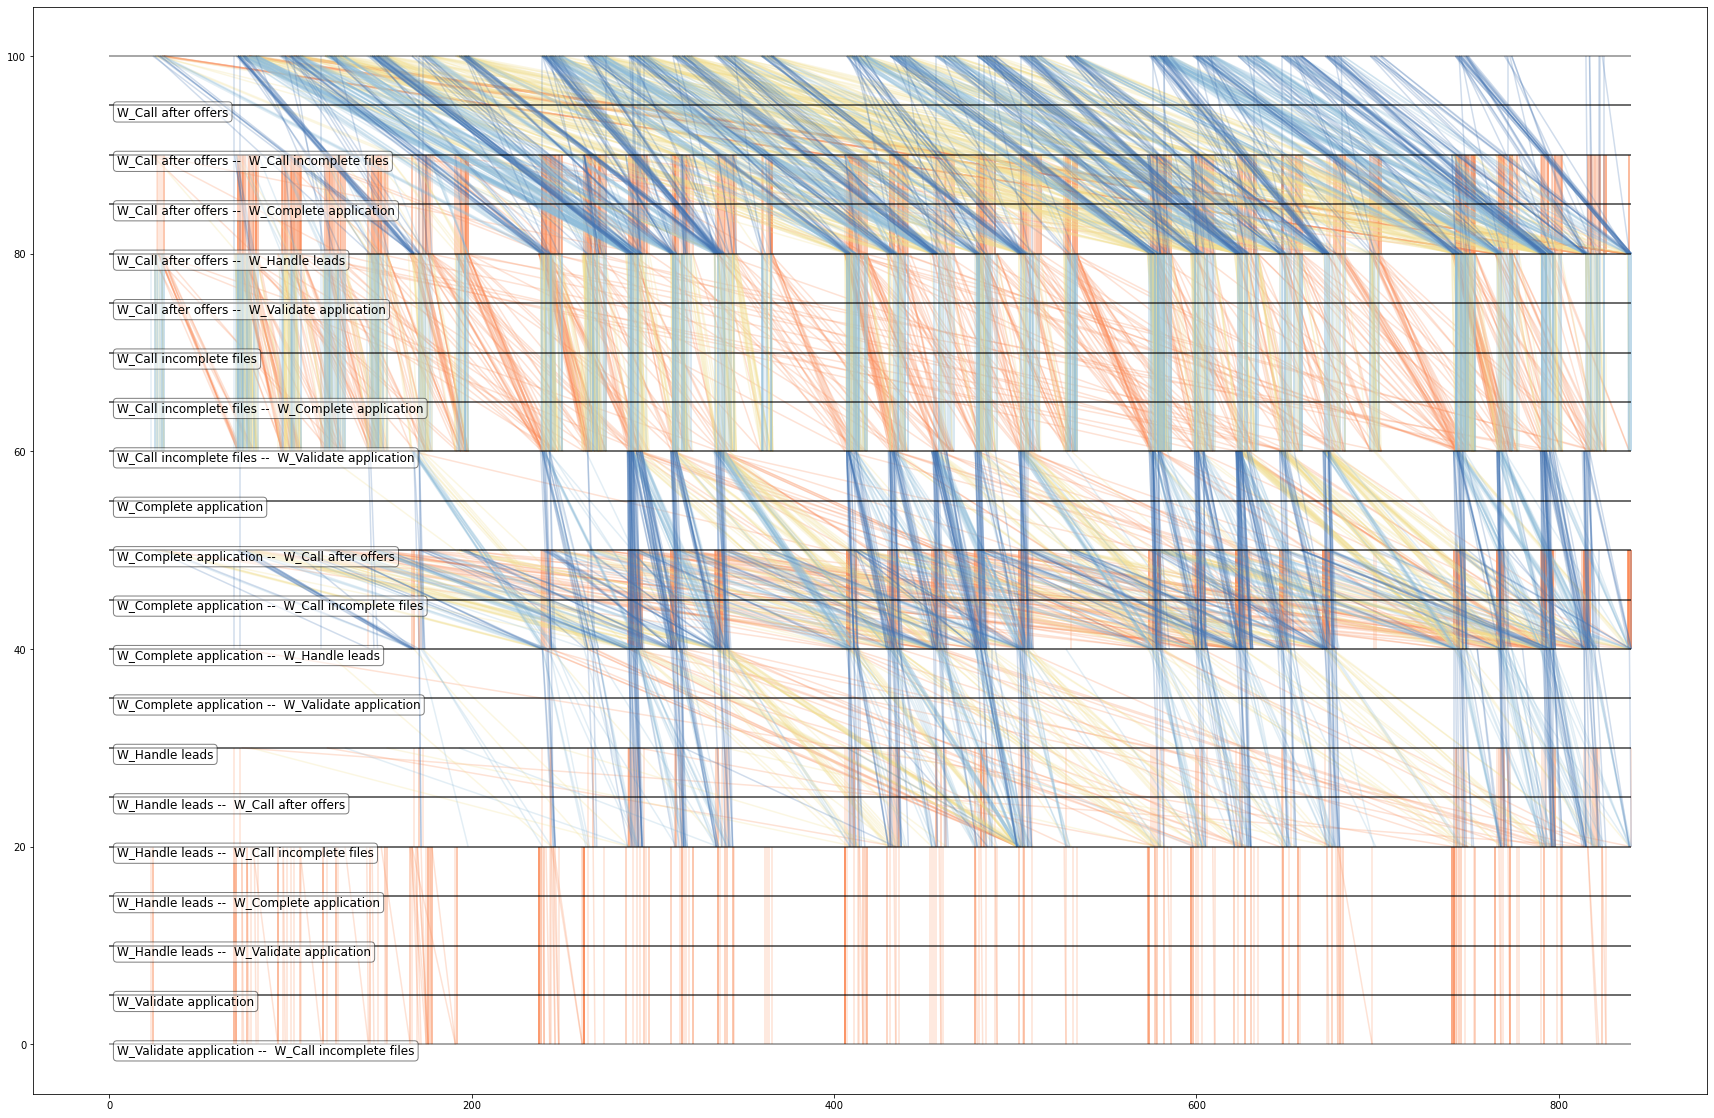

In [95]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
fig, ax = plt.subplots(figsize=[30,20])
bpi.plot_performance_spectrum(class_colors, ax, mask=(bpi.pf['end_time'] <= 5*7*24)&(bpi.pf['duration'] >= 0))

In [4]:
df = pd.read_json("C:/Users/20173939/Documents/Study/BEP/gripp_data_export_startdate_2020-01-01.json", orient='index').transpose()

In [5]:
df.columns

Index(['calendaritem', 'employmentcontract', 'company', 'payment', 'contact',
       'contract', 'contractline', 'invoice', 'invoiceline', 'ledger',
       'purchasepayment', 'purchaseinvoice', 'purchaseinvoiceline',
       'purchaseorder', 'purchaseorderline', 'costheading', 'employee', 'hour',
       'offer', 'offerphase', 'offerprojectline', 'project', 'projectphase',
       'packet', 'packetline', 'unit', 'task', 'taskphase', 'tasktype', 'tag',
       'priceexception', 'product', 'absencerequest', 'absencerequestline'],
      dtype='object')

In [6]:
df['project_id'] = [df['project'][i]['id'] if df['project'][i] else np.nan for i in range(len(df))]

In [7]:
df['calendaritem'][0]

{'createdon': '2020-01-02 09:15:33',
 'updatedon': '2020-01-02 13:28:44',
 '_ordering': '2',
 'id': '25524',
 'searchname': '',
 'subject': 'Bouwbesluitberekeningen ',
 'date': '2020-01-03',
 'hours': '6.66666',
 'calendaritememployee_id': '100438',
 'completedon': None,
 'time': None,
 'timelineentry_id': None,
 'task_id': '11253',
 'extendedproperties': None}

In [8]:
df['employmentcontract'][0]

{'createdon': '2020-01-07 15:32:39',
 'updatedon': None,
 'id': '61',
 'startdate': '2019-12-01',
 'enddate': '2030-12-01',
 'employee_id': '95619',
 'hours_monday_odd': '6.5',
 'hours_tuesday_odd': '8.5',
 'hours_wednesday_odd': '8.5',
 'hours_thursday_odd': '8.5',
 'hours_friday_odd': '6.5',
 'hours_saturday_odd': '0',
 'hours_sunday_odd': '0',
 'hours_monday_even': '6.5',
 'hours_tuesday_even': '8.5',
 'hours_wednesday_even': '8.5',
 'hours_thursday_even': '8.5',
 'hours_friday_even': '6.5',
 'hours_saturday_even': '0',
 'hours_sunday_even': '0',
 'internal_price_per_hour': '50.00'}

In [9]:
df['payment'][0]

{'createdon': '2020-01-02 08:59:22',
 'updatedon': '2020-01-06 10:44:34',
 '_ordering': None,
 'id': '9822',
 'searchname': '',
 'invoice_id': '9612',
 'date': '2020-01-03',
 'amount': '151.25',
 'notes': 'Betaling ontvangen via online betaling',
 'extendedproperties': None,
 'paymentprovider_id': '2',
 'transactionid': 'tr_pNRFznAbDU'}

In [10]:
df['product'][0]

{'createdon': '2020-01-07 08:53:59',
 'updatedon': None,
 'id': '229',
 'searchname': 'Beoordeling (20194)',
 'name': 'Beoordeling',
 'unit_id': '1',
 'sellingprice': '85.00',
 'convertto_id': '1',
 'vat_id': '27',
 'buyingvat_id': '127',
 'tasktype_id': '1',
 'costheading_id': '8',
 'ledger_id': '17',
 'internalnote': '',
 'hideontimetrackingform': '0',
 'purchaseledger_id': '34',
 'invoicebasis_id': '1',
 'description': '',
 'number': '20194',
 'archived': '0',
 'extendedproperties': None,
 'supplierordercode': '',
 'supplier_id': None,
 'buyingprice': '0.00'}

In [11]:
df

calendaritem  \
0     {'createdon': '2020-01-02 09:15:33', 'updatedo...   
1     {'createdon': '2020-01-06 08:43:44', 'updatedo...   
2     {'createdon': '2020-01-06 10:19:45', 'updatedo...   
3     {'createdon': '2020-01-06 12:12:56', 'updatedo...   
4     {'createdon': '2020-01-06 12:12:56', 'updatedo...   
...                                                 ...   
3759                                               None   
3760                                               None   
3761                                               None   
3762                                               None   
3763                                               None   

                                     employmentcontract  \
0     {'createdon': '2020-01-07 15:32:39', 'updatedo...   
1                                                  None   
2                                                  None   
3                                                  None   
4                                                  None   
...                                                 ...   
3759                                               None   
3760                                               None   
3761                                               None   
3762                                               None   
3763                                               None   

                                                company  \
0     {'updatedon': '2020-01-09 14:36:00', 'id': '10...   
1     {'updatedon': None, 'id': '102506', 'searchnam...   
2     {'updatedon': None, 'id': '102507', 'searchnam...   
3     {'updatedon': None, 'id': '102509', 'searchnam...   
4     {'updatedon': None, 'id': '102511', 'searchnam...   
...                                                 ...   
3759                                               None   
3760                                               None   
3761                                               None   
3762                                               None   
3763                                               None   

                                                payment  \
0     {'createdon': '2020-01-02 08:59:22', 'updatedo...   
1     {'createdon': '2020-01-06 09:22:17', 'updatedo...   
2     {'createdon': '2020-01-06 09:22:23', 'updatedo...   
3     {'createdon': '2020-01-06 09:22:30', 'updatedo...   
4     {'createdon': '2020-01-06 09:22:32', 'updatedo...   
...                                                 ...   
3759                                               None   
3760                                               None   
3761                                               None   
3762                                               None   
3763                                               None   

                                                contact contract contractline  \
0     {'screenname': '', 'updatedon': None, 'id': '1...     None         None   
1     {'screenname': '', 'updatedon': None, 'id': '1...     None         None   
2     {'screenname': '', 'updatedon': None, 'id': '1...     None         None   
3     {'screenname': '', 'updatedon': None, 'id': '1...     None         None   
4     {'screenname': '', 'updatedon': None, 'id': '1...     None         None   
...                                                 ...      ...          ...   
3759                                               None     None         None   
3760                                               None     None         None   
3761                                               None     None         None   
3762                                               None     None         None   
3763                                               None     None         None   

                                                invoice  \
0     {'createdon': '2020-01-02 09:03:16', 'updatedo...   
1     {'createdon': '2020-01-02 09:58:52', 'updatedo...   
2     {'createdon': '2020-01-02 12:51:03', 'updatedo...  